# Prediksi Tuberkulosis Menggunakan Artificial Neural Network (ANN) dan Random Forest
## Metodologi: CRISP-DM

Notebook ini mengimplementasikan enam tahapan utama CRISP-DM:
1. Business Understanding  
2. Data Understanding  
3. Data Preparation  
4. Modeling  
5. Evaluation  
6. Deployment

## 1. Business Understanding

Tujuan penelitian ini adalah membangun model klasifikasi untuk memprediksi apakah seorang pasien
berpotensi menderita tuberkulosis (TBC) berdasarkan data gejala dan informasi klinis yang telah
dikodekan dalam bentuk numerik.

Manfaat yang diharapkan:
- Membantu proses screening awal TBC.
- Mendukung tenaga kesehatan dalam pengambilan keputusan.
- Mengurangi waktu dan biaya pemeriksaan lanjutan yang tidak perlu.

In [1]:

# 2. DATA UNDERSTANDING - Import Library (Versi VS Code + venv lokal)

import sys
print("Python:", sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

from sklearn.ensemble import RandomForestClassifier  # <--- tambah ini

import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)

Python: 3.10.19 (main, Nov 21 2025, 10:27:29) [Clang 14.0.3 (clang-1403.0.22.14.1)]


2025-11-25 23:33:36.632973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.15.0
NumPy: 1.23.5


## 2. Data Understanding

Pada tahap ini dilakukan pemahaman struktur data, jumlah record, tipe fitur, dan distribusi label.

In [2]:

# Load dataset asli (492 baris)
filename = "tuberculosis_labeled.csv"
df = pd.read_csv(filename, sep=";")

print("Shape data:", df.shape)
display(df.head())

# Info struktur data
df.info()

# Distribusi label
print("\nDistribusi label (kolom Prediksi):")
print(df["Prediksi"].value_counts())


Shape data: (492, 17)


,CO,NS,BD,FV,CP,SP,IS,LP,CH,LC,IR,LA,LE,LN,SB,BMI,Prediksi
0,0,2,2,1,2,0,1,1,1,2,2,1,1,1,0,0,Ya
1,0,0,2,0,1,1,0,1,0,2,2,0,0,0,2,1,Tidak
2,1,1,2,0,2,0,1,2,2,2,0,1,0,2,2,0,Tidak
3,0,0,1,2,0,0,1,0,0,1,1,0,1,1,1,0,Tidak
4,1,2,1,1,0,2,2,1,0,1,2,0,2,0,1,1,Ya


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CO        492 non-null    int64 
 1   NS        492 non-null    int64 
 2   BD        492 non-null    int64 
 3   FV        492 non-null    int64 
 4   CP        492 non-null    int64 
 5   SP        492 non-null    int64 
 6   IS        492 non-null    int64 
 7   LP        492 non-null    int64 
 8   CH        492 non-null    int64 
 9   LC        492 non-null    int64 
 10  IR        492 non-null    int64 
 11  LA        492 non-null    int64 
 12  LE        492 non-null    int64 
 13  LN        492 non-null    int64 
 14  SB        492 non-null    int64 
 15  BMI       492 non-null    int64 
 16  Prediksi  492 non-null    object
dtypes: int64(16), object(1)
memory usage: 65.5+ KB

Distribusi label (kolom Prediksi):
Prediksi
Ya       333
Tidak    159
Name: count, dtype: int64


## 3. Data Preparation

Tahapan ini meliputi:
- Memisahkan fitur (X) dan label (y).
- Melakukan encoding label `Prediksi` dari teks (`'Ya'`, `'Tidak'`) menjadi angka (0/1).
- Membagi data menjadi train dan test (20% data sebagai test).
- Melakukan oversampling **hanya pada data train** untuk menyeimbangkan kelas.
- Melakukan standardisasi fitur menggunakan `StandardScaler`.

In [3]:
# 3. DATA PREPARATION

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan label
X = df.drop("Prediksi", axis=1)
y = df["Prediksi"]

# Kalau mau pastikan urutan fitur sesuai app.py:
FEATURE_COLS = ["CO", "NS", "BD", "FV", "CP", "SP", "IS", "LP",
                "CH", "LC", "IR", "LA", "LE", "LN", "SB", "BMI"]

# Kalau semua FEATURE_COLS ada di dataframe, urutkan
if all(col in X.columns for col in FEATURE_COLS):
    X = X[FEATURE_COLS]
else:
    # fallback: pakai urutan kolom di CSV
    FEATURE_COLS = X.columns.tolist()

print("FEATURE_COLS:", FEATURE_COLS)

# Encode label: 'Tidak' -> 0, 'Ya' -> 1
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Kelas label:", le.classes_)

# Split train-test (20% test, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Cek distribusi label di train & test
print("\nDistribusi label di TRAIN:")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

print("\nDistribusi label di TEST:")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))


# =============================
# OVERSAMPLING HANYA PADA DATA TRAIN
# =============================

# Gabungkan kembali X_train & y_train ke DataFrame
train_df = X_train.copy()
train_df["Prediksi"] = y_train

# Pisah per kelas (0 = Tidak, 1 = Ya)
train_class0 = train_df[train_df["Prediksi"] == 0]
train_class1 = train_df[train_df["Prediksi"] == 1]

n0 = len(train_class0)
n1 = len(train_class1)
max_n = max(n0, n1)

print("Jumlah awal TRAIN per kelas:", {"0": n0, "1": n1})
print("Target per kelas setelah oversampling:", max_n)

# Sample dengan pengulangan sampai seimbang
train_class0_over = train_class0.sample(n=max_n, replace=True, random_state=42)
train_class1_over = train_class1.sample(n=max_n, replace=True, random_state=42)

train_over = pd.concat([train_class0_over, train_class1_over], ignore_index=True)

# Pisah lagi X_train_over & y_train_over
X_train_over = train_over.drop("Prediksi", axis=1)
y_train_over = train_over["Prediksi"].values

print("Shape TRAIN setelah oversampling:", X_train_over.shape)
unique, counts = np.unique(y_train_over, return_counts=True)
print("Distribusi label TRAIN oversampled:", dict(zip(unique, counts)))


# =============================
# STANDARDISASI FITUR
# fit di TRAIN oversampled, transform ke TRAIN & TEST
# =============================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_over)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape :", X_test_scaled.shape)


FEATURE_COLS: ['CO', 'NS', 'BD', 'FV', 'CP', 'SP', 'IS', 'LP', 'CH', 'LC', 'IR', 'LA', 'LE', 'LN', 'SB', 'BMI']
Kelas label: ['Tidak' 'Ya']
Train shape: (393, 16) Test shape: (99, 16)

Distribusi label di TRAIN:
{0: 127, 1: 266}

Distribusi label di TEST:
{0: 32, 1: 67}
Jumlah awal TRAIN per kelas: {'0': 127, '1': 266}
Target per kelas setelah oversampling: 266
Shape TRAIN setelah oversampling: (532, 16)
Distribusi label TRAIN oversampled: {0: 266, 1: 266}
X_train_scaled shape: (532, 16)
X_test_scaled shape : (99, 16)


## 4. Modeling

Epoch 1/50
17/17 [==============================] - 4s 64ms/step - loss: 0.7108 - accuracy: 0.5602 - val_loss: 0.5658 - val_accuracy: 0.7677
Epoch 2/50
17/17 [==============================] - 0s 6ms/step - loss: 0.5619 - accuracy: 0.7256 - val_loss: 0.4732 - val_accuracy: 0.8687
Epoch 3/50
17/17 [==============================] - 0s 18ms/step - loss: 0.4849 - accuracy: 0.7989 - val_loss: 0.4025 - val_accuracy: 0.9091
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.4143 - accuracy: 0.8365 - val_loss: 0.3400 - val_accuracy: 0.9192
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.3267 - accuracy: 0.8966 - val_loss: 0.2875 - val_accuracy: 0.9192
Epoch 6/50
17/17 [==============================] - 0s 6ms/step - loss: 0.2757 - accuracy: 0.9305 - val_loss: 0.2513 - val_accuracy: 0.9293
Epoch 7/50
17/17 [==============================] - 0s 22ms/step - loss: 0.2484 - accuracy: 0.9211 - val_loss: 0.2185 - val_accuracy: 0.9293
Epoch 8/50
17/17 

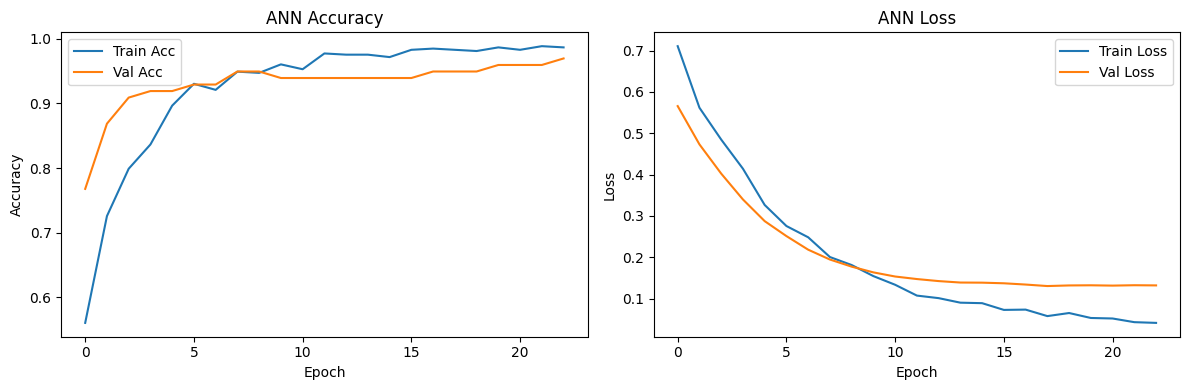

✅ Training ANN dan Random Forest selesai.


In [4]:
# 4. MODELING

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# 4.1 Modeling dengan Artificial Neural Network (ANN)

input_dim = X_train_scaled.shape[1]  # jumlah fitur

model = Sequential([
    Dense(32, activation="relu", input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled,      # pakai data TRAIN yang sudah oversampled & scaled
    y_train_over,        # label hasil oversampling
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Visualisasi training
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ANN Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ANN Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 4.2 Modeling dengan Random Forest

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train_over)

print("✅ Training ANN dan Random Forest selesai.")


## 5. Evaluation

4/4 [==============================] - 0s 4ms/step
=== ANN (Deep Learning) ===
Accuracy : 0.9494949494949495
Precision: 0.9558823529411765
Recall   : 0.9701492537313433
F1-Score : 0.9629629629629629

=== Random Forest ===
Accuracy : 0.9797979797979798
Precision: 0.9850746268656716
Recall   : 0.9850746268656716
F1-Score : 0.9850746268656716


,Metrik,ANN (Deep Learning),Random Forest
0,Accuracy,0.9495,0.9798
1,Precision,0.9559,0.9851
2,Recall,0.9701,0.9851
3,F1-Score,0.9630,0.9851


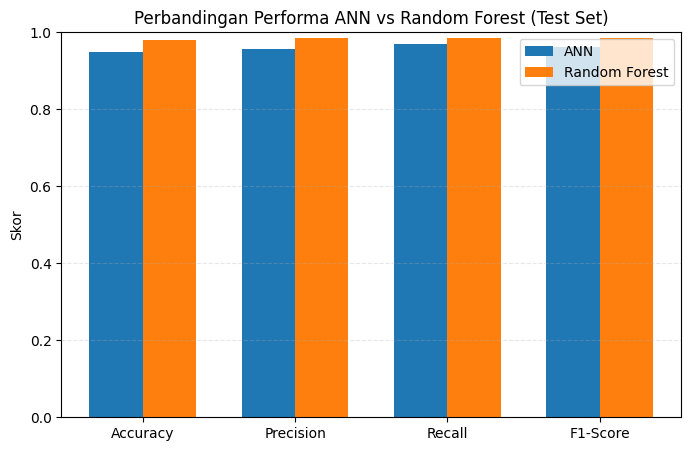


Confusion Matrix - ANN


,Pred 0,Pred 1
Actual 0 (Tidak TBC),29,3
Actual 1 (TBC),2,65



Confusion Matrix - Random Forest


,Pred 0,Pred 1
Actual 0 (Tidak TBC),31,1
Actual 1 (TBC),1,66



Classification Report - ANN
              precision    recall  f1-score   support

       Tidak       0.94      0.91      0.92        32
          Ya       0.96      0.97      0.96        67

    accuracy                           0.95        99
   macro avg       0.95      0.94      0.94        99
weighted avg       0.95      0.95      0.95        99


Classification Report - Random Forest
              precision    recall  f1-score   support

       Tidak       0.97      0.97      0.97        32
          Ya       0.99      0.99      0.99        67

    accuracy                           0.98        99
   macro avg       0.98      0.98      0.98        99
weighted avg       0.98      0.98      0.98        99



In [5]:
# 5. EVALUATION

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

# Evaluasi di TEST set (tanpa oversampling)

# Prediksi ANN
y_prob_ann = model.predict(X_test_scaled).reshape(-1)
y_pred_ann = (y_prob_ann > 0.5).astype(int)

# Prediksi Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)

def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

acc_ann, prec_ann, rec_ann, f1_ann = compute_metrics(y_test, y_pred_ann)
acc_rf,  prec_rf,  rec_rf,  f1_rf  = compute_metrics(y_test, y_pred_rf)

print("=== ANN (Deep Learning) ===")
print("Accuracy :", acc_ann)
print("Precision:", prec_ann)
print("Recall   :", rec_ann)
print("F1-Score :", f1_ann)
print()
print("=== Random Forest ===")
print("Accuracy :", acc_rf)
print("Precision:", prec_rf)
print("Recall   :", rec_rf)
print("F1-Score :", f1_rf)

# Tabel perbandingan metrik
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score"]
ann_values = [acc_ann, prec_ann, rec_ann, f1_ann]
rf_values  = [acc_rf,  prec_rf,  rec_rf,  f1_rf]

df_compare = pd.DataFrame({
    "Metrik": metrics_names,
    "ANN (Deep Learning)": ann_values,
    "Random Forest": rf_values,
})
display(df_compare.style.format({
    "ANN (Deep Learning)": "{:.4f}",
    "Random Forest": "{:.4f}",
}))

# Plot bar perbandingan
x = np.arange(len(metrics_names))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, ann_values, width, label="ANN")
plt.bar(x + width/2, rf_values,  width, label="Random Forest")
plt.xticks(x, metrics_names)
plt.ylim(0, 1)
plt.ylabel("Skor")
plt.title("Perbandingan Performa ANN vs Random Forest (Test Set)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()

# Confusion Matrix ANN & RF
cm_ann = confusion_matrix(y_test, y_pred_ann)
cm_rf = confusion_matrix(y_test, y_pred_rf)

labels_cm = ["Actual 0 (Tidak TBC)", "Actual 1 (TBC)"]
cols_cm   = ["Pred 0", "Pred 1"]

print("\nConfusion Matrix - ANN")
display(pd.DataFrame(cm_ann, index=labels_cm, columns=cols_cm))

print("\nConfusion Matrix - Random Forest")
display(pd.DataFrame(cm_rf, index=labels_cm, columns=cols_cm))

print("\nClassification Report - ANN")
print(classification_report(
    y_test, y_pred_ann,
    target_names=le.classes_,
    zero_division=0
))

print("\nClassification Report - Random Forest")
print(classification_report(
    y_test, y_pred_rf,
    target_names=le.classes_,
    zero_division=0
))


## 6. Deployment

In [6]:
# 6. DEPLOYMENT

import joblib

# Simpan model ANN
model.save('model_tbc_ann.h5')

# Simpan model Random Forest
joblib.dump(rf_model, 'model_tbc_rf.pkl')

# Simpan scaler dan label encoder
joblib.dump(scaler, 'scaler_tbc.pkl')
joblib.dump(le, 'labelencoder_tbc.pkl')

print("✅ Disimpan:")
print("- model_tbc_ann.h5")
print("- model_tbc_rf.pkl")
print("- scaler_tbc.pkl")
print("- labelencoder_tbc.pkl")


/Users/alifnaufaly/Documents/tugas tb paru DL pake pkl/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Disimpan:
- model_tbc_ann.h5
- model_tbc_rf.pkl
- scaler_tbc.pkl
- labelencoder_tbc.pkl
